In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches
import pickle

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [11]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac =  np.mean(ftcw['rel']) #3.11 # relative change
tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%
mmPerPercent = tcabsfac/tcwvfac

errperperc = tcabserr / tcrelerr

In [59]:
print('Shear scaling', shearfac)
print('TCW scaling', tcabsfac)

Shear scaling 0.6966596087324901
TCW scaling 1.2114590011213902


In [60]:
mmPerPercent

0.40429683764492774

Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [13]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
#cmip_tcw_map = uda.shift_lons(cmip_tcw_map)

In [14]:
cmip_tcw_map.model_name

<xarray.DataArray 'model_name' (model_name: 38)>
array(['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5',
       'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
       'CanESM2', 'FGOALS-g2', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G',
       'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC',
       'HadGEM2-CC', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR',
       'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR',
       'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-M', 'NorESM1-ME',
       'bcc-csm1-1', 'bcc-csm1-1-m', 'inmcm4'], dtype=object)
Coordinates:
  * model_name  (model_name) object 'ACCESS1-0' 'ACCESS1-3' ... 'inmcm4'

In [15]:
cmip_shear_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/u*.nc', concat_dim='model_name', combine='by_coords').load()
#cmip_tcw_map = uda.shift_lons(cmip_tcw_map)

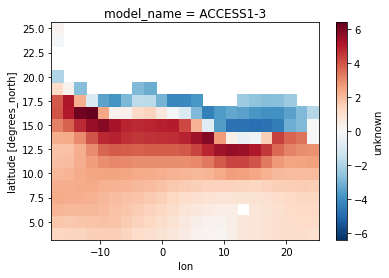

In [16]:
cmip_shear_map['unknown'].sel(lon=slice(-18,25), lat=slice(3.5,25), model_name='ACCESS1-3').plot()

In [17]:
tests = cmip_shear_map.isel(model_name=0)

In [18]:
ds_merge = xr.merge([cmip_tcw_map, cmip_shear_map])

In [19]:
ds_merge

<xarray.Dataset>
Dimensions:     (lat: 25, lon: 27, model_name: 38)
Coordinates:
  * model_name  (model_name) object 'ACCESS1-0' 'ACCESS1-3' ... 'inmcm4'
  * lat         (lat) float64 0.0 1.25 2.5 3.75 5.0 ... 26.25 27.5 28.75 30.0
  * lon         (lon) float64 -24.38 -22.5 -20.62 -18.75 ... 20.62 22.5 24.38
Data variables:
    prw         (model_name, lat, lon) float64 13.08 13.08 13.04 ... nan nan nan
    unknown     (model_name, lat, lon) float64 3.048 3.147 3.187 ... nan nan nan

In [20]:
ds_merge['unknown'] = ds_merge['unknown'].sel(lon=slice(-18,25), lat=slice(4,25))*shearfac
ds_merge['prw'] = ds_merge['prw'].sel(lon=slice(-18,25), lat=slice(4,25))*tcabsfac

In [21]:
ds_merge['sum'] = ds_merge['unknown'] + ds_merge['prw']

In [22]:
ds_merge['contribution'] = ds_merge['unknown']#/ ds_merge['sum']*100

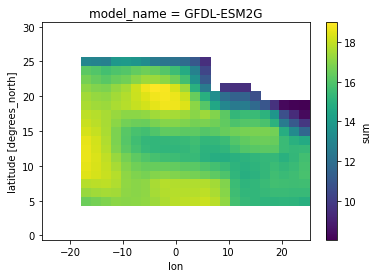

In [23]:
ds_merge['sum'].isel(model_name=15).plot()

In [24]:
p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [25]:
def percentile_contribution(p90, ds_merge):
    contr = p90.copy(deep=True)
    fillarr = np.zeros_like(p90.values)*np.nan

    for latid, lats in enumerate(p90.lat):
        for lonid, lons in enumerate(p90.lon):

            ds = ds_merge.sel(lat=lats, lon=lons)

            if np.isnan(p90.sel(lat=lats, lon=lons).values):
                continue
            
            pos = np.where(p90.sel(lat=lats, lon=lons).values == ds['sum'].values)
           # ipdb.set_trace()
            try:
                #ipdb.set_trace()
                ctr = ds['contribution'].isel(model_name=pos[0]).values
                fillarr[latid, lonid] = ctr
            except:
                print('Error')
                continue
    contr.values = fillarr
    return contr

In [26]:
contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)

In [57]:
def draw_map(ax, dat, lat, lon, title='', levels=None, cbarlabel='', cmap='', bl=False, ll=True):
    import matplotlib.ticker as mticker
    
    ax.set_facecolor('lightgrey')
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, alpha=0.7, extend='both')
    cbar = plt.colorbar()
    cbar.set_label(cbarlabel)
    plt.contour(lon, lat, dat, transform=ccrs.PlateCarree(), colors='white', levels=levels, linewidths=0.1)
    ax.coastlines()
    #Gridlines
    xl = ax.gridlines(draw_labels=True, linestyle='dotted', linewidths=0.001);
    xl.top_labels = False
    xl.right_labels = False
    xl.bottom_labels = bl
    xl.left_labels = ll
    xl.ylocator = mticker.FixedLocator([5,10,15,20])
    #xl.grid(False)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', linewidth=0.5);
    plt.title(title)
    ax.set_ylim(3.7,23.5)
    ax.set_xlim(-18,18)
    
    rect1 = patches.Rectangle((-12,9),26,11,linewidth=1.5,edgecolor='k',facecolor='none', zorder=99)
    ax.add_patch(rect1)


/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


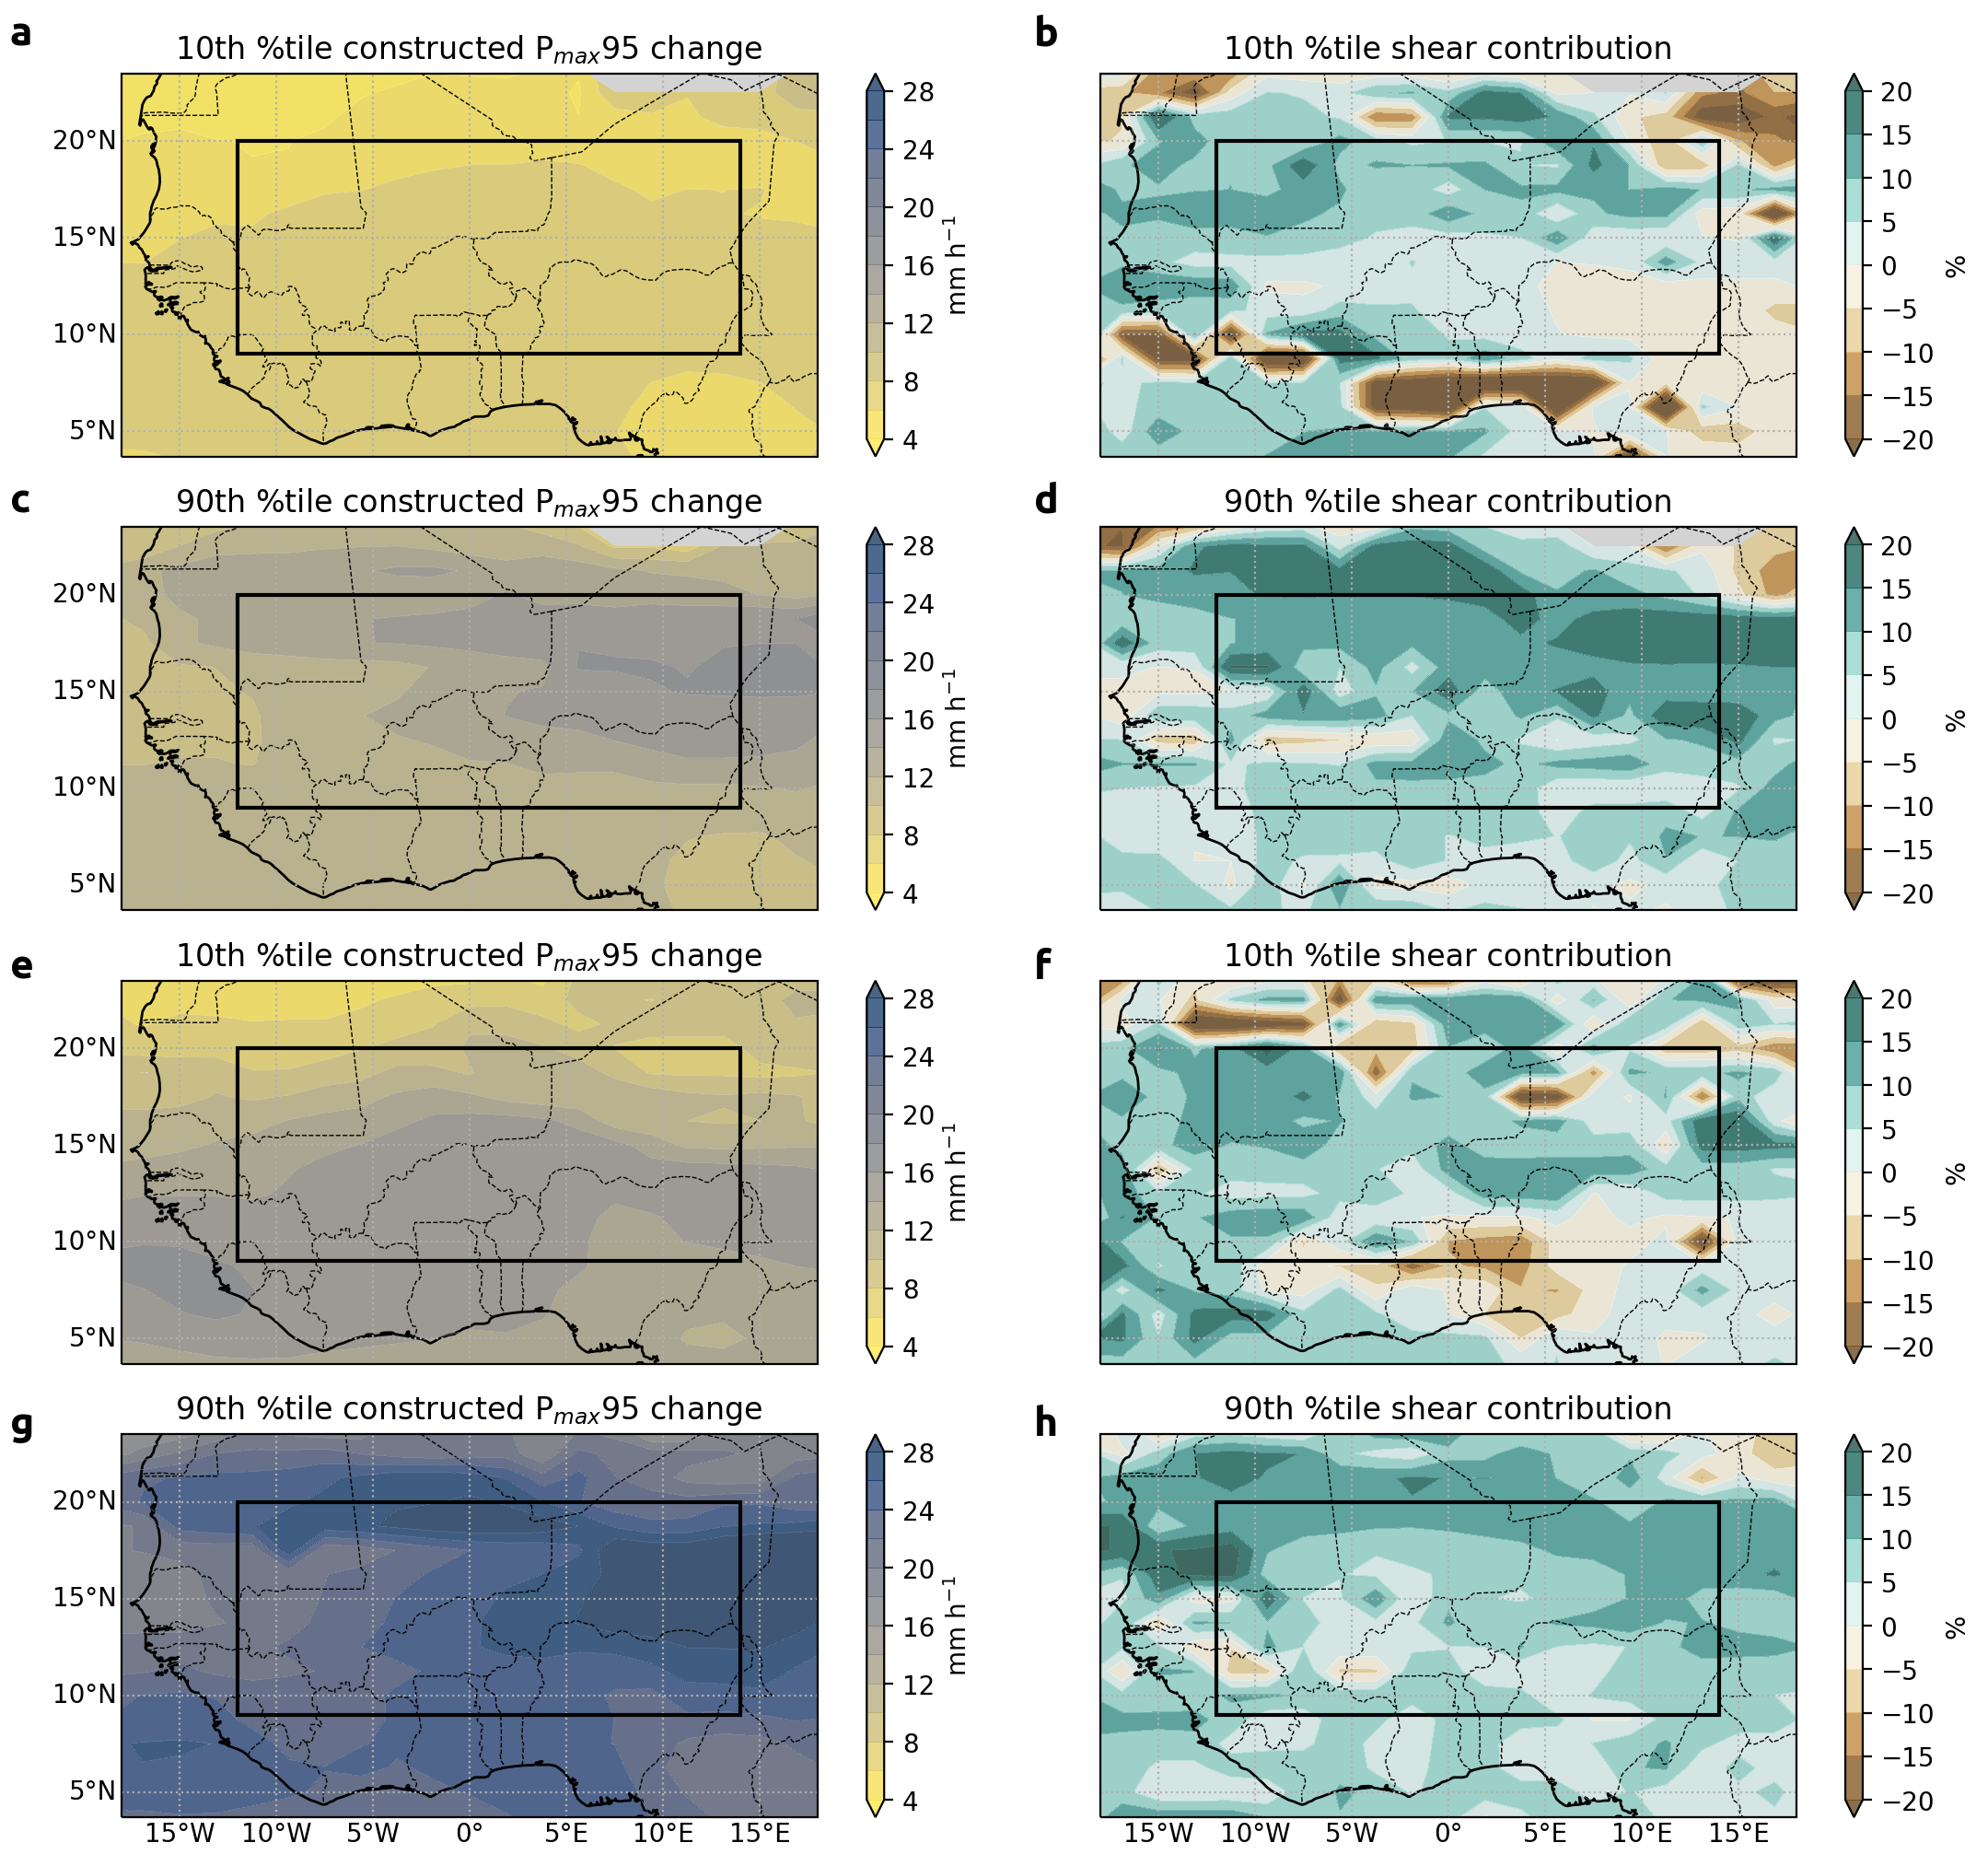

In [58]:

f = plt.figure(figsize=(11,10), dpi=200)


tag='10'
yy ='2040'
slevels=np.arange(-20,21,5)
tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*.nc', concat_dim='model_name', combine='by_coords').load()

ds_merge = xr.merge([tcw_map, sh_map])
ds_merge['unknown'] = ds_merge['unknown'].sel(lon=slice(-20,20), lat=slice(3.5,25))*shearfac
ds_merge['prw'] = ds_merge['prw'].sel(lon=slice(-20,20), lat=slice(3.5,25))*tcabsfac
ds_merge['sum'] = ds_merge['unknown'] + ds_merge['prw']
ds_merge['contribution'] = ds_merge['unknown']/ ds_merge['sum']*100

p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)

ax = f.add_subplot(4,2,1, projection=ccrs.PlateCarree())

#draw_map(ax, p10/mmPerPercent, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(5,81,5), cbarlabel=r'%', cmap='cividis_r') 
draw_map(ax, p10, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(4,30,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 
#plt.contour(ds_merge.lon, ds_merge.lat, contr10,  colors='k', linestyle='solid', linewidths=0.7, levels=[5,10,15,18,20])

ax1 = f.add_subplot(4,2,2, projection=ccrs.PlateCarree())
draw_map(ax1, contr10, ds_merge.lat, ds_merge.lon,  title=tag+'th %tile shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False) # YlOrBr

tag='90'
ax = f.add_subplot(4,2,3, projection=ccrs.PlateCarree())
#draw_map(ax, p90/ mmPerPercent, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(5,81,5), cbarlabel=r'%', cmap='cividis_r') 
draw_map(ax, p90, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(4,30,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 

ax1 = f.add_subplot(4,2,4, projection=ccrs.PlateCarree())
draw_map(ax1, contr90, ds_merge.lat, ds_merge.lon,  title=tag+'th %tile shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False)

del ds_merge
del tcw_map
del sh_map

tag='10'
yy ='2080'
tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*.nc', concat_dim='model_name', combine='by_coords').load()

ds_merge = xr.merge([tcw_map, sh_map])
ds_merge['unknown'] = ds_merge['unknown'].sel(lon=slice(-20,20), lat=slice(3.5,25))*shearfac
ds_merge['prw'] = ds_merge['prw'].sel(lon=slice(-20,20), lat=slice(3.5,25))*tcabsfac
ds_merge['sum'] = ds_merge['unknown'] + ds_merge['prw']
ds_merge['contribution'] = ds_merge['unknown']/ ds_merge['sum']*100

p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)

ax = f.add_subplot(4,2,5, projection=ccrs.PlateCarree())
draw_map(ax, p10, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(4,30,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 

ax1 = f.add_subplot(4,2,6, projection=ccrs.PlateCarree())
draw_map(ax1, contr10, ds_merge.lat, ds_merge.lon,  title=tag+'th %tile shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False)

tag='90'
ax = f.add_subplot(4,2,7, projection=ccrs.PlateCarree())
draw_map(ax, p90, ds_merge.lat, ds_merge.lon, title=tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(4,30,2), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=True) 

ax1 = f.add_subplot(4,2,8, projection=ccrs.PlateCarree())
draw_map(ax1, contr90, ds_merge.lat, ds_merge.lon,  title=tag+'th %tile shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', bl=True, ll=False)



#         cmip_tcw_wa = tcw_map['prw']
#         cmip_sh_wa = sh_map['unknown']

#         cmip_tcw_wa = cmip_tcw_wa.sel(lon=slice(-20,20), lat=slice(3.5,25))*tcabsfac / mmPerPercent
#         cmip_sh_wa = cmip_sh_wa.sel(lon=slice(-20,20), lat=slice(3.5,25))*shearfac / mmPerPercent

#         both = cmip_sh_wa / (cmip_tcw_wa+cmip_sh_wa) *100 

#         posi = num+1
        
#         if num==1:
#             numx = 4
#         else:
#             numx =0
            
#         if ids > 0:
#             ti = 1
#             tag = '90'
#         else:
#             ti = 0
#             tag = '10'
            
#         xx = (numx)+(ids+1)+ti
#         xxx = (numx)+(ids+2)+ti
        
#         # Create a Rectangle patch
#         rect = patches.Rectangle((-5,9),20,11,linewidth=2,edgecolor='k',facecolor='none')

#         # Add the patch to the Axes
        
        
#         print(xx, xxx)

#         ax = f.add_subplot(4,2,xx, projection=ccrs.PlateCarree())
#         ax.set_ylim(4,25)
#         ax.set_facecolor('lightgrey')
#         ax.add_patch(rect)
#         draw_map(ax, cmip_tcw_wa, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model+' '+tag+'th %tile constructed P$_{max}95$ change ', levels=np.arange(5,81,5), cbarlabel=r'%', cmap='cividis_r') 
        
#         ax1 = f.add_subplot(4,2,xxx, projection=ccrs.PlateCarree())
#         ax1.set_ylim(4,25)
#         ax1.set_facecolor('lightgrey')
#         rect1 = patches.Rectangle((-5,9),20,11,linewidth=2,edgecolor='k',facecolor='none')
#         ax1.add_patch(rect1)
#         draw_map(ax1, both, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model+' '+tag+'th %tile shear contribution', levels=np.arange(0,20,1), cbarlabel='%', cmap='YlOrBr')  

plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

x1 = 0.005
x2 = 0.52

plt.annotate(text[0], xy=(x1, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(x2, 0.97), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(x1, 0.72), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(x2, 0.72), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(x1, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[5], xy=(x2, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[6], xy=(x1, 0.225), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[7], xy=(x2, 0.225), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_scaled_map_rainfall_PercentileperPixel2040.jpg')